In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import os, skvideo.io, json, cv2
import zarr

In [3]:
# Fix for stupid skvideo/numpy backwards compatability fuck up
np.float = np.float64
np.int = np.int_

In [4]:
def load_data(data_dir_path):
    '''Loads all data without checking that (img,position) pair exists.'''

    data_dir = os.fsencode(data_dir_path)
    vid1_data = []
    vid2_data = []
    pos_data = []
    times2_data = []
    for dir in os.scandir(data_dir):
        if os.path.isdir(dir):
            sample_dir = os.fsencode(dir)
            sample_dir_name = os.fsdecode(sample_dir)
            try:
                for file in os.listdir(sample_dir):
                    file_name = os.fsdecode(file)
                    # timestamp = '.'.join(file_name.split('_')[1].split('.')[:2])
                    file_type = file_name.split('_')[0]
                    if file_type=='video1':
                        videodata1 = skvideo.io.vread(f'{sample_dir_name}/{file_name}')
                    elif file_type=='video2':
                        videodata2 = skvideo.io.vread(f'{sample_dir_name}/{file_name}')
                    elif file_type=='positions':
                        with open(f'{sample_dir_name}/{file_name}', 'r') as f:
                            position = json.load(f)
                    elif file_type=='times2':
                        with open(f'{sample_dir_name}/{file_name}', 'r') as f:
                            times2 = json.load(f)

                vid1_data.append(videodata1)
                vid2_data.append(videodata2)
                pos_data.append(position)
                times2_data.append(times2)
            except FileNotFoundError as e:
                print(f"Bad data {sample_dir_name}: {e}")
            except ValueError as e:
                print(f"Bad video file in {sample_dir_name}: {e}")
            except Exception as e:
                print(sample_dir_name, file)
                raise e

    return vid1_data, vid2_data, pos_data, times2_data

In [5]:
data_dir = "data/toucht/"
vid1_data, vid2_data, pos_data, times2_data = load_data(data_dir)

Bad video file in data/toucht/save_folder_46: No way to determine width or height from video. Need `-s` in `inputdict`. Consult documentation on I/O.


In [6]:
dataset_complete = len(vid1_data) == len(vid2_data) and len(vid1_data) == len(pos_data) and len(vid1_data) == len(times2_data)
dataset_size = len(vid1_data)
print(f'All data values for each sample: {dataset_complete}, dataset size: {dataset_size}')

pos_clean = [list(pos.values()) for pos in pos_data]
vid1_clean = [vid for vid in vid1_data]
vid2_clean = [vid for vid in vid2_data]
times1_clean = [list(pos.keys()) for pos in pos_data]
times2_clean = [times for times in times2_data]

All data values for each sample: True, dataset size: 40


In [7]:
samples_len_agree = True
bad_idxs = []
for n in range(dataset_size):
    p1 = len(pos_clean[n]) == len(vid1_clean[n])
    p2 = len(pos_clean[n]) == len(vid2_clean[n])
    p3 = len(pos_clean[n]) == len(times2_clean[n])
    samples_len_agree = p1 and p2 and p3

    if not samples_len_agree:
        bad_idxs += [n]
        print(f'Bad sample lengths at index: {n}')

dataset_size = dataset_size - len(bad_idxs)
pos_clean = [val for n, val in enumerate(pos_clean) if n not in bad_idxs]
vid1_clean = [val for n, val in enumerate(vid1_clean) if n not in bad_idxs]
vid2_clean = [val for n, val in enumerate(vid2_clean) if n not in bad_idxs]
times1_clean = [val for n, val in enumerate(times1_clean) if n not in bad_idxs]
times2_clean = [val for n, val in enumerate(times2_clean) if n not in bad_idxs]
episode_lengths = [len(val) for val in pos_clean]
print(f'Cleaned datset size: {dataset_size}')

Cleaned datset size: 40


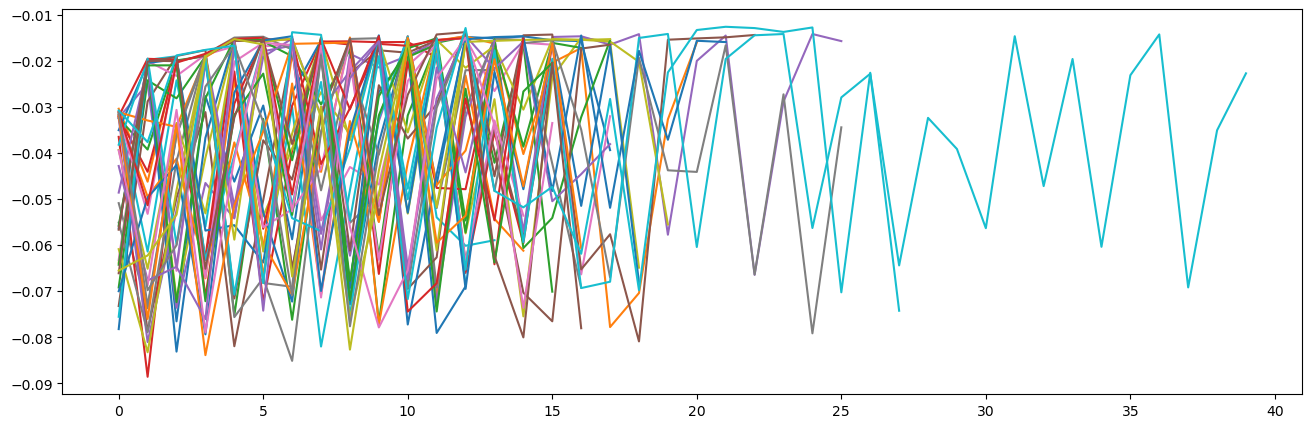

In [8]:
fig= plt.figure(figsize=(16,5))

for n in range(dataset_size):
    times1 = np.array(times1_clean[n], dtype=float)
    times2 = np.array(times2_clean[n], dtype=float)
    plt.plot(times1-times2)

plt.show()

/tmp/ipykernel_2149504/1545043077.py:10: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


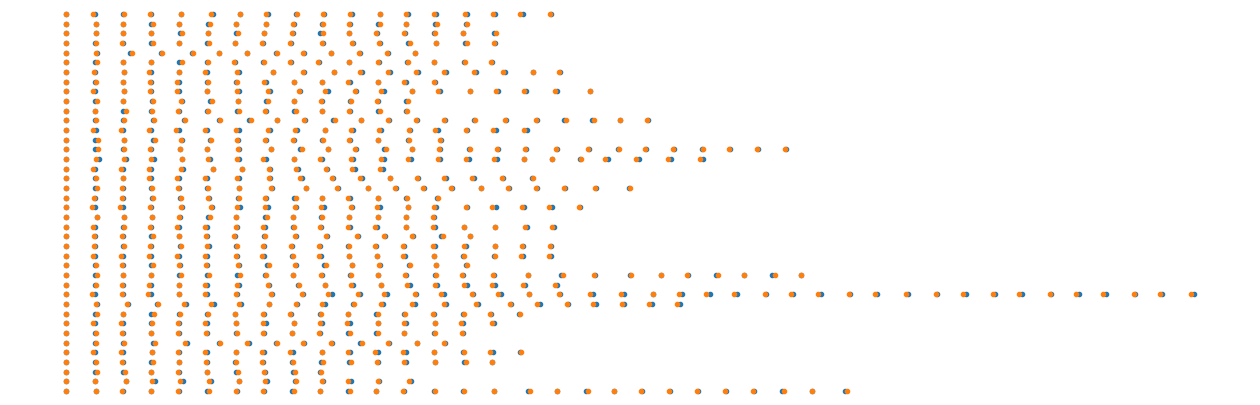

In [9]:
fig, axs = plt.subplots(nrows=dataset_size, ncols=1, figsize=(16,5), sharex=True)

for n,ax in enumerate(axs):
    times = np.array(times1_clean[n], dtype=float)
    ax.scatter(times-times[0], np.ones_like(times), marker='.')
    times = np.array(times2_clean[n], dtype=float)
    ax.scatter(times-times[0], np.ones_like(times), marker='.')
    ax.axis('off')

plt.tight_layout()
plt.show()

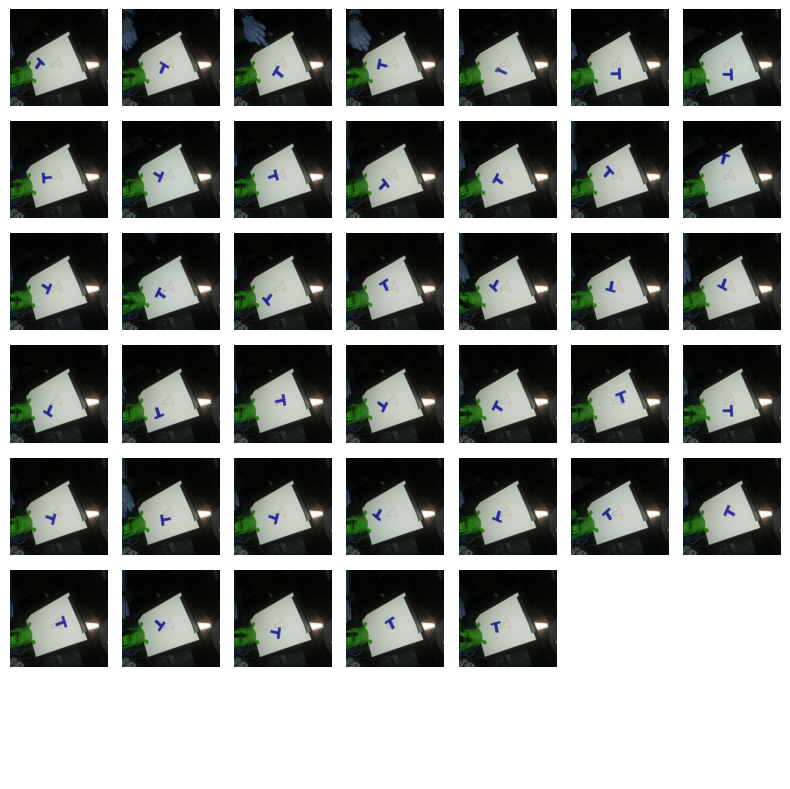

In [10]:
plot_dim = int(np.ceil(np.sqrt(dataset_size)))
fig, axs = plt.subplots(ncols=plot_dim,nrows=plot_dim, figsize=(8,8))

for n, ax in enumerate(axs):
    for m, a in enumerate(ax):
        if n*plot_dim + m < dataset_size:
            a.imshow(vid1_clean[n*plot_dim + m][0])
        a.axis('off')

plt.tight_layout()
plt.show()

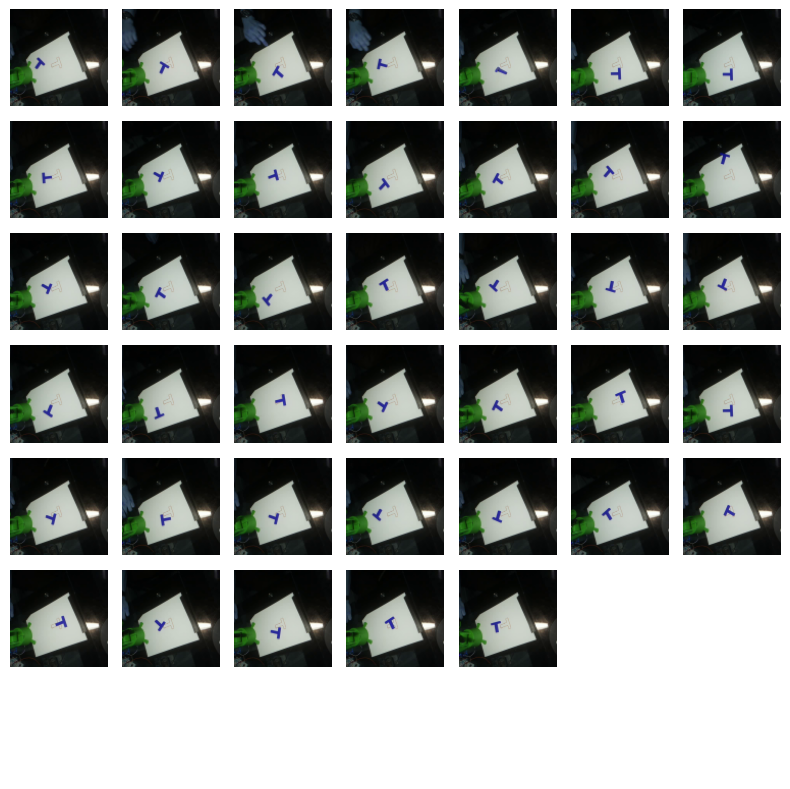

In [11]:
plot_dim = int(np.ceil(np.sqrt(dataset_size)))
fig, axs = plt.subplots(ncols=plot_dim,nrows=plot_dim, figsize=(8,8))

for n, ax in enumerate(axs):
    for m, a in enumerate(ax):
        if n*plot_dim + m < dataset_size:
            a.imshow(
                cv2.resize(
                    vid1_clean[n*plot_dim + m][0],
                    (96, 96), interpolation=cv2.INTER_AREA
                )
            )
        a.axis('off')

plt.tight_layout()
plt.show()

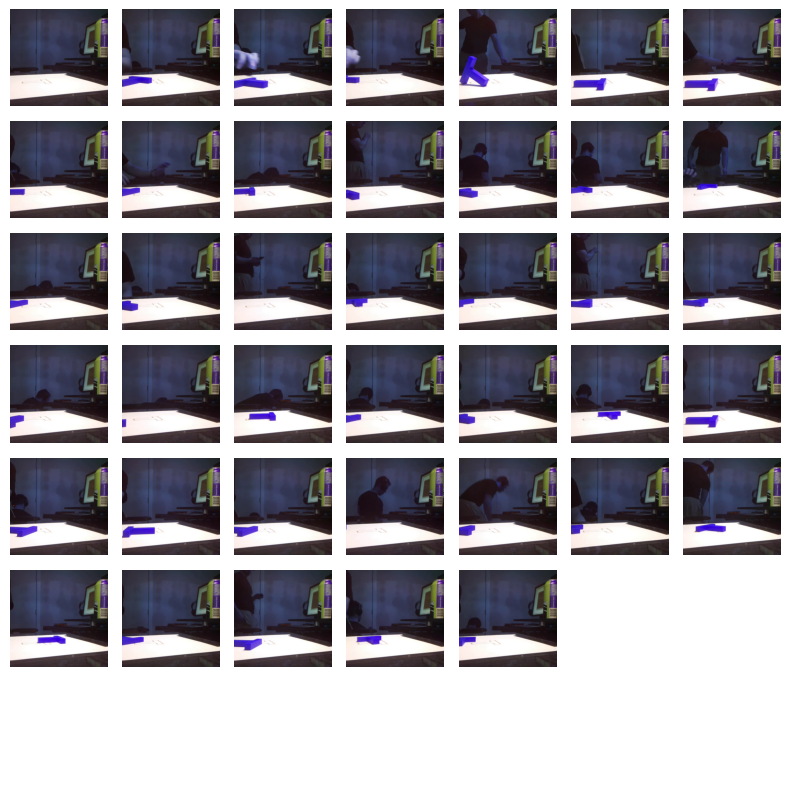

In [12]:
plot_dim = int(np.ceil(np.sqrt(dataset_size)))
fig, axs = plt.subplots(ncols=plot_dim,nrows=plot_dim, figsize=(8,8))

for n, ax in enumerate(axs):
    for m, a in enumerate(ax):
        if n*plot_dim + m < dataset_size:
            a.imshow(vid2_clean[n*plot_dim + m][0])
        a.axis('off')

plt.tight_layout()
plt.show()

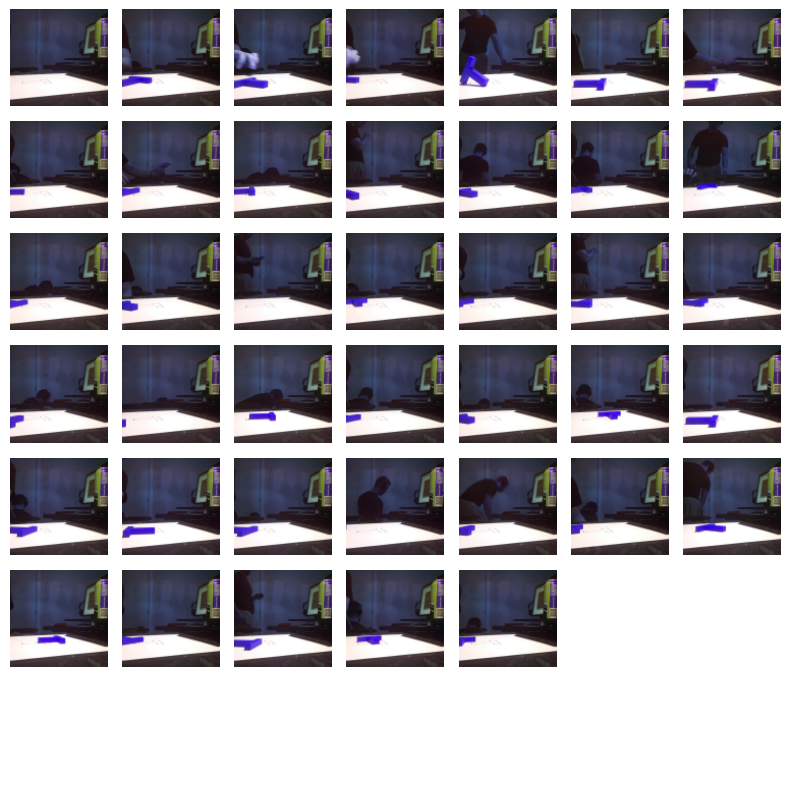

In [13]:
plot_dim = int(np.ceil(np.sqrt(dataset_size)))
fig, axs = plt.subplots(ncols=plot_dim,nrows=plot_dim, figsize=(8,8))

for n, ax in enumerate(axs):
    for m, a in enumerate(ax):
        if n*plot_dim + m < dataset_size:
            a.imshow(
                cv2.resize(
                    vid2_clean[n*plot_dim + m][0],
                    (96, 96), interpolation=cv2.INTER_AREA
                )
            )
        a.axis('off')

plt.tight_layout()
plt.show()

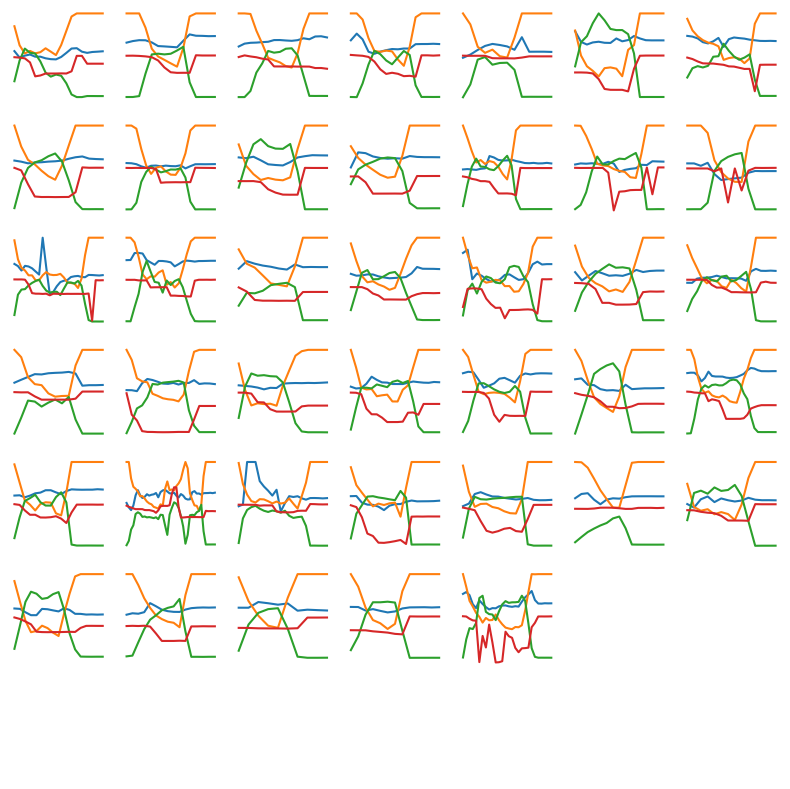

In [14]:
plot_dim = int(np.ceil(np.sqrt(dataset_size)))
fig, axs = plt.subplots(ncols=plot_dim,nrows=plot_dim, figsize=(8,8), sharey=True)

for n, ax in enumerate(axs):
    for m, a in enumerate(ax):
        if n*plot_dim + m < dataset_size:
            a.plot(pos_clean[n*plot_dim + m])
        a.axis('off')

plt.tight_layout()
plt.show()

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = vid1_data[-2]

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = vid2_data[-1]

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

In [17]:
# Convert to numpy arrays
vid1_array = np.vstack(vid1_clean)
vid2_array = np.vstack(vid2_clean)
pos_array = np.vstack(pos_clean)
times1_array = np.concatenate([np.array(a, dtype=float) for a in times1_clean])
times2_array = np.concatenate([np.array(a, dtype=float) for a in times2_clean])

In [18]:
# Compute actions from positions: action[n] = position[n+1], end action repeats

act_array = np.zeros_like(pos_array)
start_idx = 0
for length in episode_lengths:
    end_idx = start_idx + length - 1
    act_array[start_idx:end_idx] = pos_array[(start_idx+1):(end_idx+1)]
    act_array[end_idx] = pos_array[end_idx]
    start_idx += length

In [32]:
episode_lengths

[18,
 15,
 16,
 16,
 13,
 16,
 18,
 14,
 19,
 13,
 13,
 21,
 17,
 14,
 26,
 23,
 12,
 17,
 20,
 14,
 19,
 14,
 18,
 15,
 18,
 18,
 15,
 26,
 18,
 40,
 22,
 17,
 16,
 15,
 14,
 17,
 16,
 10,
 13,
 28]

In [31]:
# Save dataset in zarr
store = zarr.ZipStore("data/toucht.zarr.zip", mode='w')
toucht_zarr = zarr.group(store=store)
toucht_data = toucht_zarr.create_group('data')
toucht_meta = toucht_zarr.create_group('meta')
toucht_data['img1'] = vid1_array.astype(np.float32)
toucht_data['img2'] = vid2_array.astype(np.float32)
toucht_data['state'] = pos_array.astype(np.float32)
toucht_data['action'] = act_array.astype(np.float32)
toucht_meta['episode_ends'] = np.cumsum(episode_lengths)
toucht_meta['master_time'] = times1_array
toucht_meta['slave_time'] = times2_array
print(toucht_zarr.tree())
store.close()

/
 ├── data
 │   ├── action (704, 4) float32
 │   ├── img1 (704, 512, 512, 3) float32
 │   ├── img2 (704, 512, 512, 3) float32
 │   └── state (704, 4) float32
 └── meta
     ├── episode_ends (40,) int64
     ├── master_time (704,) float64
     └── slave_time (704,) float64


In [20]:
russ_data = zarr.open("data/pusht_cchi_v7_replay.zarr.zip", 'r')
print(russ_data.tree())

/
 ├── data
 │   ├── action (25650, 2) float32
 │   ├── img (25650, 96, 96, 3) float32
 │   ├── keypoint (25650, 9, 2) float32
 │   ├── n_contacts (25650, 1) float32
 │   └── state (25650, 5) float32
 └── meta
     └── episode_ends (206,) int64


In [29]:
russ_data['meta']['episode_ends'][-1]

25650

In [28]:
np.sum(russ_data['meta']['episode_ends'])

2612905

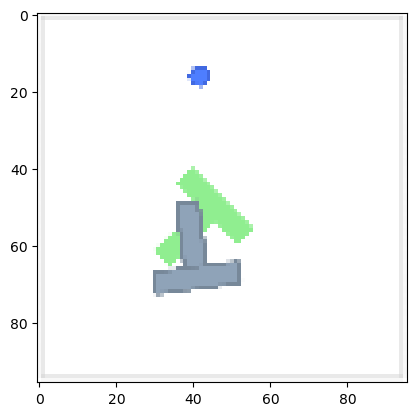

In [21]:
plt.imshow(russ_data['data']['img'][1].astype(np.int))
plt.show()

In [22]:
positions = russ_data['data/state']